In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
# ============================================
# 1) IMPORT LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Notebook style (optional)
sns.set_style("whitegrid")
%matplotlib inline

In [4]:
df = pd.read_csv("/Users/yashswinkapil/Downloads/airlines_flights_data.csv", encoding="latin1")
print("Shape:", df.shape)
df.head()

Shape: (300153, 12)


,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [5]:
# ============================================
# 3) QUICK DATA EXPLORATION
# ============================================
df.info()
df.describe(include="all").T

# Drop the useless index column if present
if "index" in df.columns:
    df = df.drop(columns=["index"])

# Check missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [7]:
# ============================================
# 4) FEATURE ENGINEERING / CLEANING
# ============================================

# ---- 4A) Clean duration into minutes ----
# duration examples often look like: "2h 50m", "9h 5m", "1h", "55m"
def duration_to_minutes(x):
    x = str(x).lower().strip()
    hours = 0
    mins = 0

    if "h" in x:
        # split around 'h'
        parts = x.split("h")
        try:
            hours = int(parts[0].strip())
        except:
            hours = 0

        # remaining part may contain minutes
        if len(parts) > 1 and "m" in parts[1]:
            try:
                mins = int(parts[1].replace("m", "").strip())
            except:
                mins = 0
    else:
        # no hours, maybe only minutes
        if "m" in x:
            try:
                mins = int(x.replace("m", "").strip())
            except:
                mins = 0

    return hours * 60 + mins

df["duration_mins"] = df["duration"].apply(duration_to_minutes)

In [8]:
# ---- 4B) Create target label (binary) ----
# Expensive = top 25% of prices (change to 0.50 for median, or 0.80 for top 20%, etc.)
threshold = df["price"].quantile(0.75)
df["expensive"] = (df["price"] >= threshold).astype(int)

print("Expensive threshold (75th percentile):", threshold)
df[["price", "expensive"]].head()


Expensive threshold (75th percentile): 42521.0


,price,expensive
0,5953,0
1,5953,0
2,5956,0
3,5955,0
4,5955,0


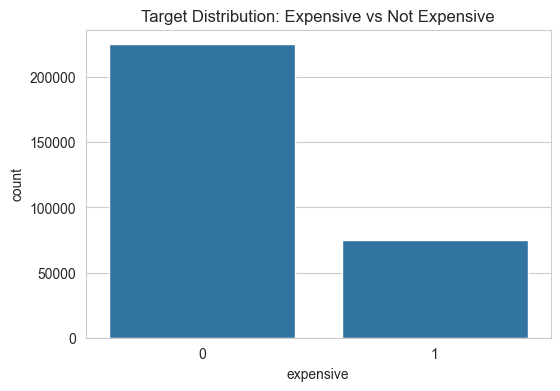

In [9]:
# ============================================
# 5) EDA (VISUALIZATIONS + INSIGHTS)
# ============================================

# 5A) Target balance
plt.figure(figsize=(6,4))
sns.countplot(x="expensive", data=df)
plt.title("Target Distribution: Expensive vs Not Expensive")
plt.show()

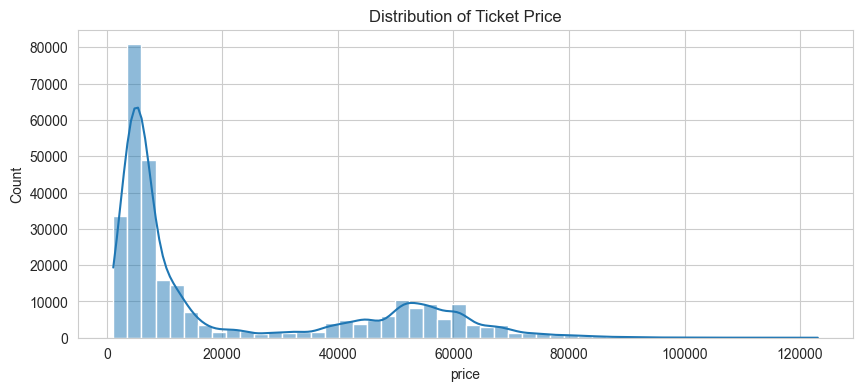

In [10]:
# 5B) Price distribution
plt.figure(figsize=(10,4))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribution of Ticket Price")
plt.show()

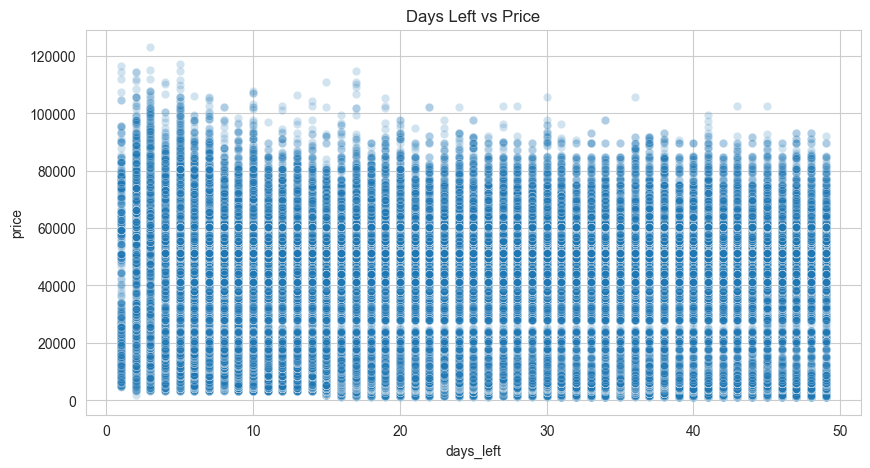

In [11]:
# 5C) Days left vs Price
plt.figure(figsize=(10,5))
sns.scatterplot(x="days_left", y="price", data=df, alpha=0.2)
plt.title("Days Left vs Price")
plt.show()

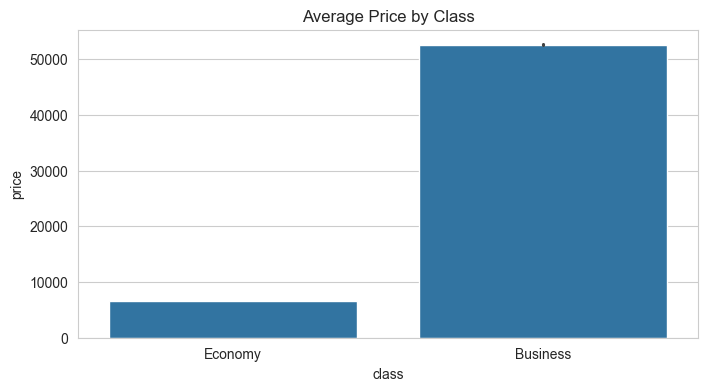

In [12]:

# 5D) Average price by class
plt.figure(figsize=(8,4))
sns.barplot(x="class", y="price", data=df, estimator=np.mean)
plt.title("Average Price by Class")
plt.show()

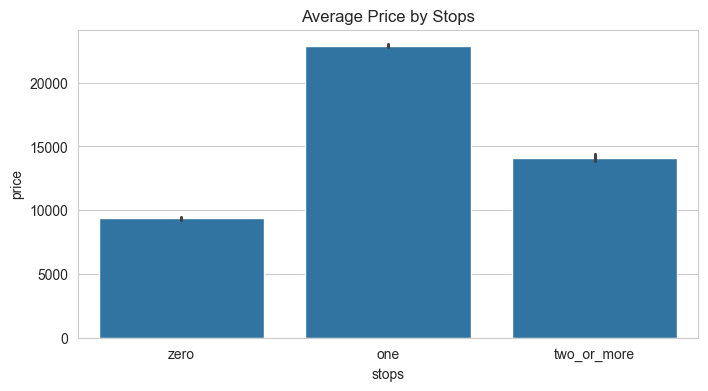

In [13]:
# 5E) Average price by stops
plt.figure(figsize=(8,4))
sns.barplot(x="stops", y="price", data=df, estimator=np.mean)
plt.title("Average Price by Stops")
plt.show()


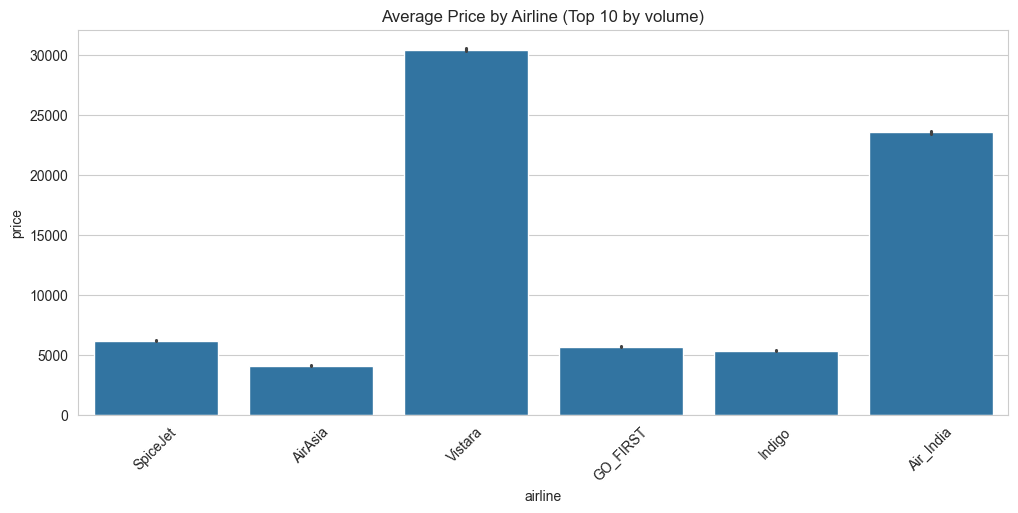

In [14]:
# 5F) Average price by airline (Top 10 airlines by count)
top_airlines = df["airline"].value_counts().head(10).index
plt.figure(figsize=(12,5))
sns.barplot(x="airline", y="price", data=df[df["airline"].isin(top_airlines)], estimator=np.mean)
plt.title("Average Price by Airline (Top 10 by volume)")
plt.xticks(rotation=45)
plt.show()

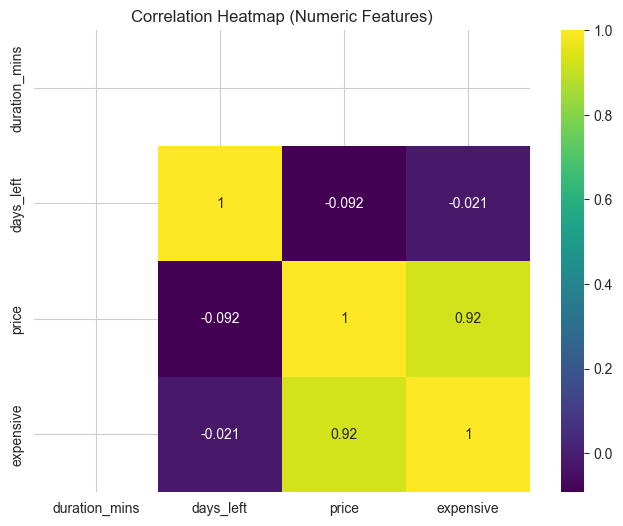

In [15]:
# 5G) Correlation heatmap (numeric)
plt.figure(figsize=(8,6))
numeric_cols = ["duration_mins", "days_left", "price", "expensive"]
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="viridis")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [16]:
# ============================================
# 6) MODELING SETUP
# ============================================

# Features (X) and target (y)
# We'll drop raw duration string + price (since price is used to create the label)
X = df.drop(columns=["price", "expensive", "duration"])
y = df["expensive"]

# Identify categorical and numeric columns
categorical_features = [
    "airline", "flight", "source_city", "departure_time",
    "stops", "arrival_time", "destination_city", "class"
]
numeric_features = ["duration_mins", "days_left"]

# Preprocess:
# - OneHotEncode categoricals
# - Scale numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="drop"
)

# Model
log_model = LogisticRegression(max_iter=1000)

# Pipeline: preprocess -> model
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_model)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=101, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape :", X_test.shape, y_test.shape)


Train shape: (201102, 10) (201102,)
Test shape : (99051, 10) (99051,)


/Users/yashswinkapil/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/yashswinkapil/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/yashswinkapil/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     74245
           1       0.97      0.98      0.98     24806

    accuracy                           0.99     99051
   macro avg       0.98      0.99      0.98     99051
weighted avg       0.99      0.99      0.99     99051


CONFUSION MATRIX:

[[73565   680]
 [  461 24345]]

Precision: 0.9728271728271728
Recall   : 0.9814157865032653


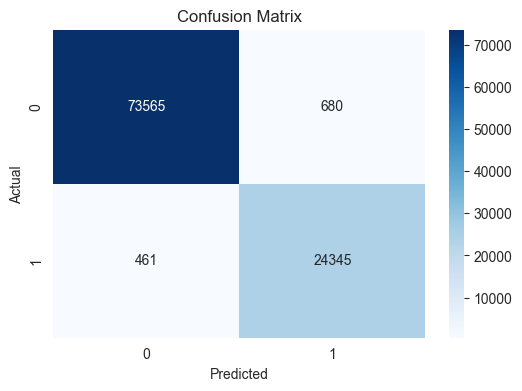

In [17]:
# ============================================
# 7) TRAIN MODEL
# ============================================
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)


# ============================================
# 8) MODEL EVALUATION
# ============================================

print("CLASSIFICATION REPORT:\n")
print(classification_report(y_test, predictions))

print("\nCONFUSION MATRIX:\n")
cm = confusion_matrix(y_test, predictions)
print(cm)

print("\nPrecision:", precision_score(y_test, predictions))
print("Recall   :", recall_score(y_test, predictions))

# Confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
# ============================================
# 9) CROSS-VALIDATION (OPTIONAL)
# ============================================
# Cross-val predictions on training set (like your old project)
y_train_pred = cross_val_predict(clf, X_train, y_train, cv=5)

print("\nTRAINING CV CONFUSION MATRIX:\n")
cm_train = confusion_matrix(y_train, y_train_pred)
print(cm_train)

print("\nTraining CV Precision:", precision_score(y_train, y_train_pred))
print("Training CV Recall   :", recall_score(y_train, y_train_pred))

/Users/yashswinkapil/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/yashswinkapil/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/yashswinkapil/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/yashswinkapil/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/yashswinkapil/Library/Python/3.9/lib/python/site


TRAINING CV CONFUSION MATRIX:

[[149373   1366]
 [   947  49416]]

Training CV Precision: 0.9731007049742034
Training CV Recall   : 0.9811965133133451
